In [161]:
# Create GAN for MDP process with two states

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class GAN:
    def __init__(self, seq_len=16, latent_dim=25):
        # self.P = np.random.uniform(0, 1, (6, 6))
        # print(self.P, np.sum(self.P, axis=1, keepdims=True))
        # self.P = self.P / np.sum(self.P, axis=1, keepdims=True)
        self.states = [0, 1]
        self.actions = [0, 1, 2]
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        # print(self.P)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        # print(self.P)

    def generate_real_samples(self, n_samples):
        X_total = []
        for i in range(n_samples):
            # current_state = np.random.choice([0, 1])
            current_state = 0
            X = []
            while len(X) < self.seq_len:
                # print(X)
                if current_state == 0:
                    ac = np.random.choice([0, 1], p=[0.7,0.3])
                    if ac == 0:
                        next_state = np.random.choice([0, 1], p=[0.9, 0.1])
                    else:
                        next_state = 1

                    ac = tf.keras.utils.to_categorical(ac, num_classes=3)
                    current_state_cat = tf.keras.utils.to_categorical(
                        current_state, num_classes=2
                    )
                    current_state = next_state
                    X.append(np.concatenate([current_state_cat, ac]))

                else:
                    ac = 2
                    next_state = 1

                    ac = tf.keras.utils.to_categorical(ac, num_classes=3)
                    current_state_cat = tf.keras.utils.to_categorical(
                        current_state, num_classes=2
                    )
                    current_state = next_state
                    X.append(np.concatenate([current_state_cat, ac]))

            X = np.array(X)
            # X = tf.keras.utils.to_categorical(X, num_classes=6)
            X_total.append(X)
        X = np.array(X_total)
        y = np.ones((n_samples, 1)) * 0.9
        # print(X.shape, y.shape)
        return X, y

    def generate_fake_samples(self, n_samples):
        X = self.generator.predict(np.random.normal(0, 1, (n_samples, 25)))
        y = np.zeros((n_samples, 1))
        return X, y

    def calculate_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        X1 = np.argmax(X[:, :, :2], axis=2)
        X2 = np.argmax(X[:, :, 2:], axis=2)
        # X1 = np.argmax(X1, axis=1)
        # X2 = np.argmax(X2, axis=1)

        print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))
        print(
            "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        )
        print(
            "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        )
        print(
            "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        )
        

    def calculate_final_P(self, n_samples):
        X, _ = self.generate_fake_samples(n_samples)
        X1 = np.argmax(X[:, :, :2], axis=2)
        X2 = np.argmax(X[:, :, 2:], axis=2)
        # X1 = np.argmax(X1, axis=1)
        # X2 = np.argmax(X2, axis=1)

        print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))
        print(
            "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        )
        print(
            "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        )
        print(
            "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        )
        ps = np.zeros((2, 3, 2))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                ps[X1[i, j], X2[i, j], X1[i, j + 1]] += 1
        ps = ps / np.sum(ps, axis=2, keepdims=True)
        print(ps)

    # def calculate_P_real(self, n_samples):
    #     X, _ = self.generate_real_samples(n_samples)
    #     X = np.argmax(X, axis=2)
    #     P = np.zeros((6, 6))
    #     for i in range(n_samples):
    #         for j in range(self.seq_len - 1):
    #             P[X[i, j], X[i, j + 1]] += 1

    #     P = P / np.sum(P, axis=1, keepdims=True)
    #     return P

    def build_generator(self):
        inp = tf.keras.layers.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(16 * 5000)(inp)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Reshape((16, 5000))(x)
        # x = tf.keras.layers.Dense(100)(x)
        y1 = tf.keras.layers.Dense(2, activation="softmax")(x)
        y2 = tf.keras.layers.Dense(3, activation="softmax")(x)
        y3 = tf.keras.layers.Dense(1, activation="linear")(x)
        y = tf.keras.layers.Concatenate()([y1, y2, y3])
        self.generator = tf.keras.models.Model(inputs=inp, outputs=y)

        # self.generator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Dense(4 * 2000, input_shape=(25,)),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Reshape((4, 2000)),
        #         tf.keras.layers.Conv1DTranspose(100, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1DTranspose(50, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1DTranspose(
        #             5, 3, strides=1, padding="same", activation="sigmoid"
        #         ),
        #     ]
        # )
        # inp = tf.keras.layers.Input(shape=(25,))
        # x = self.generator(inp)
        # y1 = tf.keras.layers.Conv1DTranspose(
        #     2, 3, strides=1, padding="same", activation="softmax"
        # )(x)
        # y2 = tf.keras.layers.Conv1DTranspose(
        #     3, 3, strides=1, padding="same", activation="softmax"
        # )(x)
        # y = tf.keras.layers.Concatenate()([y1, y2])
        # self.generator = tf.keras.models.Model(inputs=inp, outputs=y)

    def summarize_generator(self):
        self.generator.summary()
        # tf.keras.utils.plot_model(self.generator, show_shapes=True, dpi=64)

    def build_discriminator(self):
        self.discriminator = tf.keras.models.Sequential(
            [
                tf.keras.layers.Input(shape=(self.seq_len, 5)),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(5000, activation="relu"),
                # tf.keras.layers.Dense(100, activation="relu"),
                # tf.keras.layers.Dense(10, activation="relu"),
                tf.keras.layers.Dense(1, activation="sigmoid"),
            ]
        )
        # self.discriminator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Conv1D(
        #             50, 3, strides=2, padding="same", input_shape=(self.seq_len, 5)
        #         ),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1D(100, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1D(200, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Flatten(),
        #         tf.keras.layers.Dense(1, activation="sigmoid"),
        #     ]
        # )
        self.discriminator.compile(
            loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5),
            metrics=["accuracy"],
        )

    def summarize_discriminator(self):
        self.discriminator.summary()
        # tf.keras.utils.plot_model(self.discriminator, show_shapes=True, dpi=64)

    def build_gan(self):
        self.discriminator.trainable = False
        self.gan = tf.keras.models.Sequential(
            [
                self.generator,
                self.discriminator,
            ]
        )
        self.gan.compile(
            loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5),
        )

    def train(self, epochs=10, batch_size=128, data_size=10000):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        total = data_size // batch_size
        train_data_x, train_data_y = self.generate_real_samples(data_size)
        X1 = np.argmax(train_data_x[:, :, :2], axis=2)
        X2 = np.argmax(train_data_x[:, :, 2:], axis=2)
        print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))
        print(
            "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        )
        print(
            "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        )
        print(
            "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        )
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator

            for k in range(total):
                print(k, "/", total, end="\r")
                idx = np.random.randint(0, data_size, batch_size // 2)
                X_real, y_real = train_data_x[idx], train_data_y[idx]
                X_fake, y_fake = self.generate_fake_samples(batch_size // 2)

                l1, ac1 = self.discriminator.train_on_batch(X_real, y_real)
                l2, ac2 = self.discriminator.train_on_batch(X_fake, y_fake)

                X_fake = np.random.normal(0, 1, (batch_size, self.latent_dim))
                y_fake = np.ones((batch_size, 1))
                l3 = self.gan.train_on_batch(X_fake, y_fake)

                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)

            # Show plots of the losses and accuracies
            calc_p = self.calculate_P(10000)
            # print(calc_p)
            # pred = gan.generator.predict(np.random.normal(0, 1, (1, gan.latent_dim)))
            # print(pred)
            # print(gan.discriminator.predict(pred))
            # print("Loss:",np.mean(np.abs(calc_p - (self.P))))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

In [162]:
gan = GAN()

In [163]:
gan.summarize_discriminator()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 80)                0         
                                                                 
 dense_77 (Dense)            (None, 5000)              405000    
                                                                 
 dense_78 (Dense)            (None, 1)                 5001      
                                                                 
Total params: 410,001
Trainable params: 0
Non-trainable params: 410,001
_________________________________________________________________


In [164]:
gan.summarize_generator()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 25)]         0           []                               
                                                                                                  
 dense_74 (Dense)               (None, 80000)        2080000     ['input_28[0][0]']               
                                                                                                  
 leaky_re_lu_54 (LeakyReLU)     (None, 80000)        0           ['dense_74[0][0]']               
                                                                                                  
 reshape_17 (Reshape)           (None, 16, 5000)     0           ['leaky_re_lu_54[0][0]']         
                                                                                           

Probabilitity of starting position being 1: 0.49828
Probability of action 0 being taken in state 0: 0.7006876105350447
Probability of action 1 being taken in state 0: 0.29931238946495536
Probability of action 2 being taken in state 1: 1.0
Iteration: 0
313/313 [==============================] - 1s 4ms/step
Probabilitity of starting position being 1: 0.5332
Probability of action 0 being taken in state 0: 0.6274119753332007
Probability of action 1 being taken in state 0: 0.3610503282275711
Probability of action 2 being taken in state 1: 0.9987262081015832


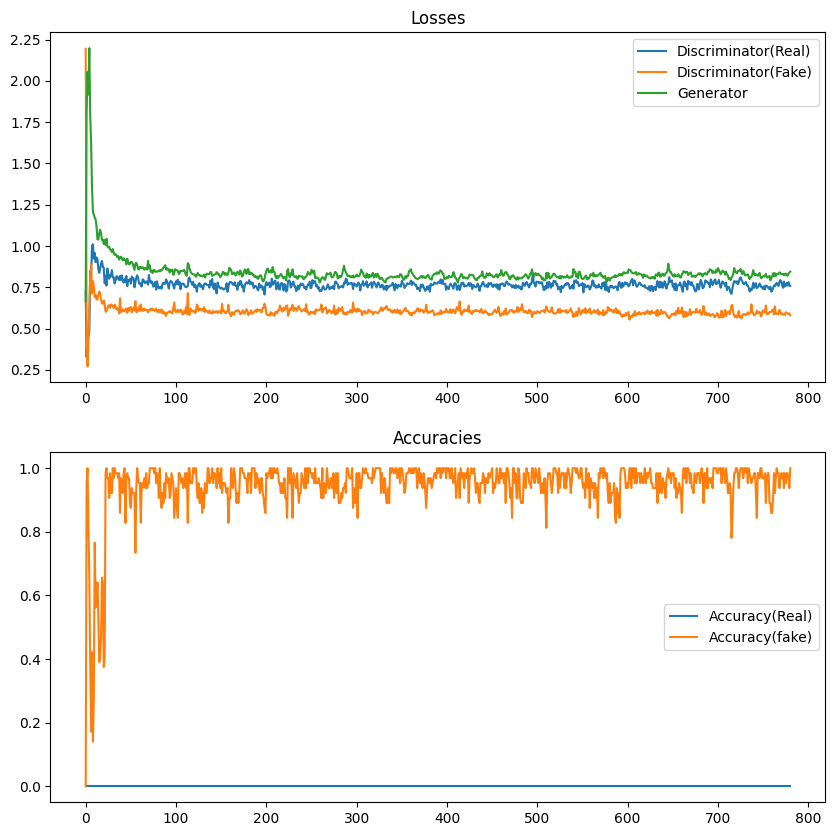

Iteration: 1
313/313 [==============================] - 1s 4ms/step
Probabilitity of starting position being 1: 0.5275
Probability of action 0 being taken in state 0: 0.5795669539625815
Probability of action 1 being taken in state 0: 0.4157031742694976
Probability of action 2 being taken in state 1: 0.9981925228924949


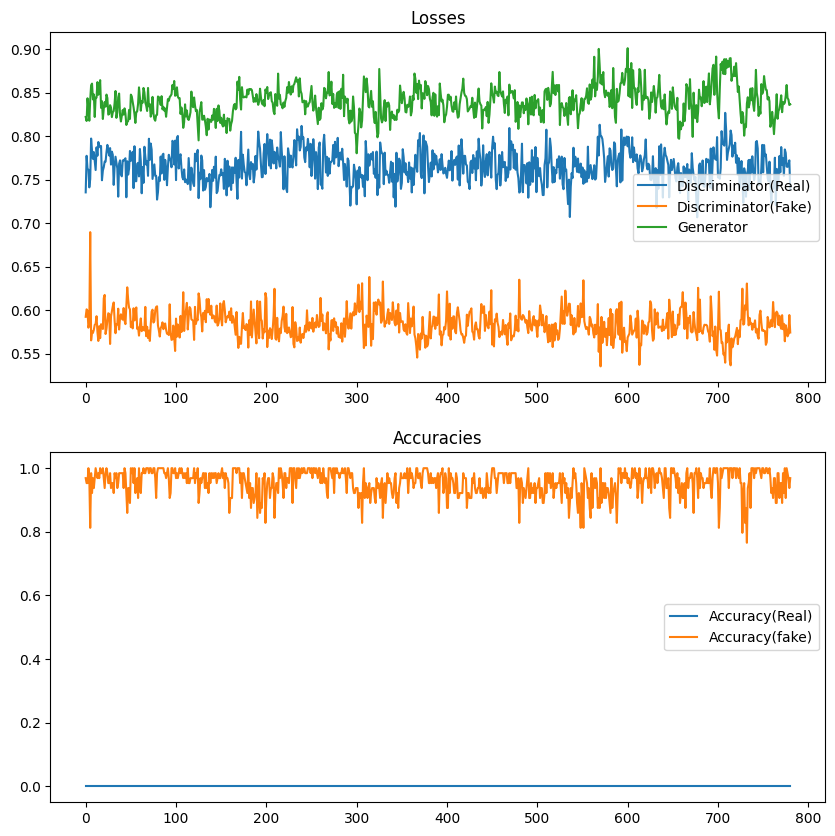

Iteration: 2
313/313 [==============================] - 1s 4ms/step
Probabilitity of starting position being 1: 0.5548
Probability of action 0 being taken in state 0: 0.6054593290944968
Probability of action 1 being taken in state 0: 0.3889497917123438
Probability of action 2 being taken in state 1: 0.9990455865003512


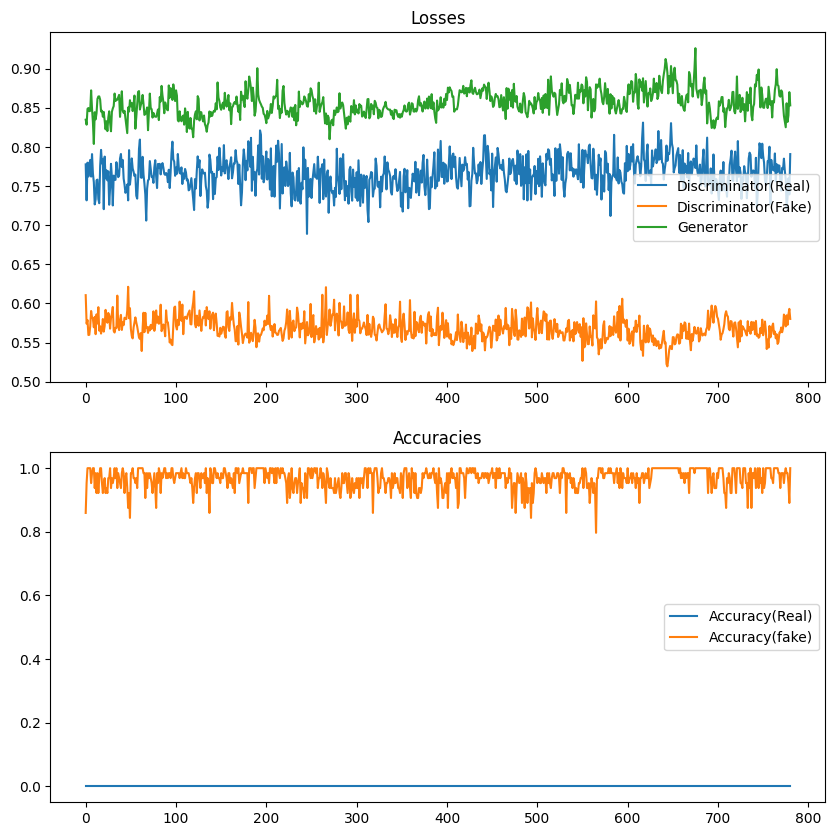

Iteration: 3
313/313 [==============================] - 1s 4ms/step
Probabilitity of starting position being 1: 0.5511
Probability of action 0 being taken in state 0: 0.5820183902826654
Probability of action 1 being taken in state 0: 0.41151095470541493
Probability of action 2 being taken in state 1: 0.9985713435323531


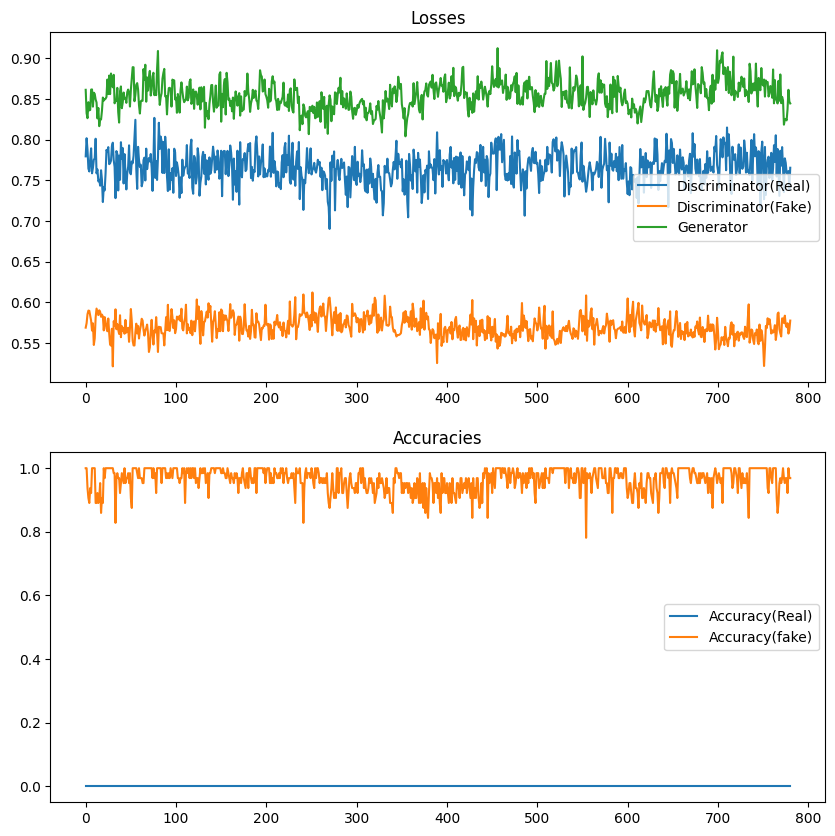

Iteration: 4
313/313 [==============================] - 3s 4ms/step
Probabilitity of starting position being 1: 0.5678
Probability of action 0 being taken in state 0: 0.47781665500349896
Probability of action 1 being taken in state 0: 0.5181245626312107
Probability of action 2 being taken in state 1: 0.9989140034673383


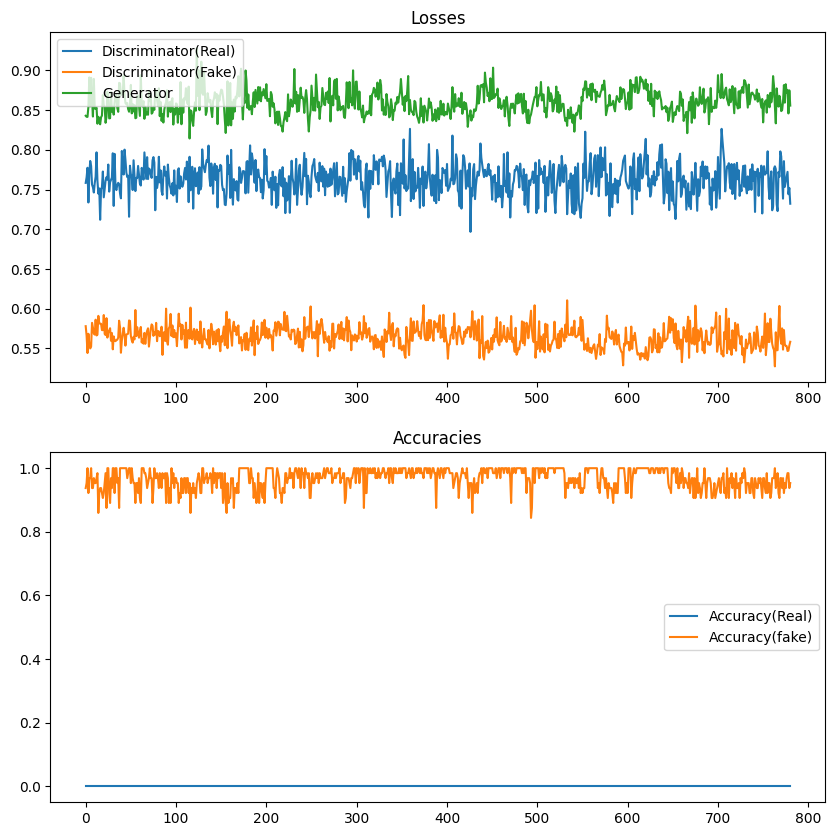

In [165]:
gan.train(epochs=5, batch_size=128, data_size=1000)

In [111]:
real, _ = gan.generate_real_samples(10)
fake, _ = gan.generate_fake_samples(10)

1/1 [==============================] - 0s 24ms/step


In [115]:
print(real[2])

[[1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]]


In [125]:
print(np.rint(fake[9]))

[[1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1.]]


In [132]:
gan.calculate_final_P(1000000)

31250/31250 [==============================] - 77s 2ms/step
Probabilitity of starting position being 1: 0.545047
Probability of action 0 being taken in state 0: 0.5852819823811634
Probability of action 1 being taken in state 0: 0.40839086374226374
Probability of action 2 being taken in state 1: 0.9993375523830305
[[[7.59032271e-01 2.40967729e-01]
  [9.25723385e-03 9.90742766e-01]
  [2.67319277e-02 9.73268072e-01]]

 [[4.42051573e-01 5.57948427e-01]
  [3.07031010e-04 9.99692969e-01]
  [4.77300961e-04 9.99522699e-01]]]
